In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
# Load data
df = pd.read_csv('./finalalldata.csv')

# Prepare features and target
X = df.drop(columns=['label','uid'])
y = df['label']

In [3]:

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Handle missing values in numeric columns
if numeric_cols:
    X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Handle missing values and encode categorical columns
if categorical_cols:
    for col in categorical_cols:
        X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 'missing')
    
    # One-hot encode categorical variables
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Ensure all columns are numeric
X = X.astype(float)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)  # Binary classification
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

In [4]:

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [5]:

# Define Neural Network with 2 hidden layers (halving dimensions)
input_dim = X_train.shape[1]
hidden1_dim = X_train.shape[1]//2
hidden2_dim = 7

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1_dim)
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.fc3 = nn.Linear(hidden2_dim, 1)  # Binary classification output
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x


In [6]:

# Initialize model
model = NeuralNetwork(input_dim, hidden1_dim, hidden2_dim)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:

# Training
num_epochs = 300
print("Training started...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')


Training started...
Epoch [20/300], Loss: 0.3508
Epoch [40/300], Loss: 0.3160
Epoch [60/300], Loss: 0.3169
Epoch [80/300], Loss: 0.3011
Epoch [100/300], Loss: 0.3139
Epoch [120/300], Loss: 0.2787
Epoch [140/300], Loss: 0.2992
Epoch [160/300], Loss: 0.3112
Epoch [180/300], Loss: 0.2887
Epoch [200/300], Loss: 0.2596
Epoch [220/300], Loss: 0.2813
Epoch [240/300], Loss: 0.2683
Epoch [260/300], Loss: 0.2826
Epoch [280/300], Loss: 0.2929
Epoch [300/300], Loss: 0.2605


In [15]:
checkpoint = torch.load('binary_model.pth',weights_only=False)
model = NeuralNetwork(
    checkpoint['input_dim'], 
    checkpoint['hidden1_dim'], 
    checkpoint['hidden2_dim']
)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


NeuralNetwork(
  (fc1): Linear(in_features=15, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=7, bias=True)
  (fc3): Linear(in_features=7, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (sigmoid): Sigmoid()
)


===== TEST RESULTS =====
Loss: 1.3948
Accuracy: 0.8346

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      0.69      0.72        39
     Class 1       0.87      0.90      0.88        88

    accuracy                           0.83       127
   macro avg       0.81      0.80      0.80       127
weighted avg       0.83      0.83      0.83       127



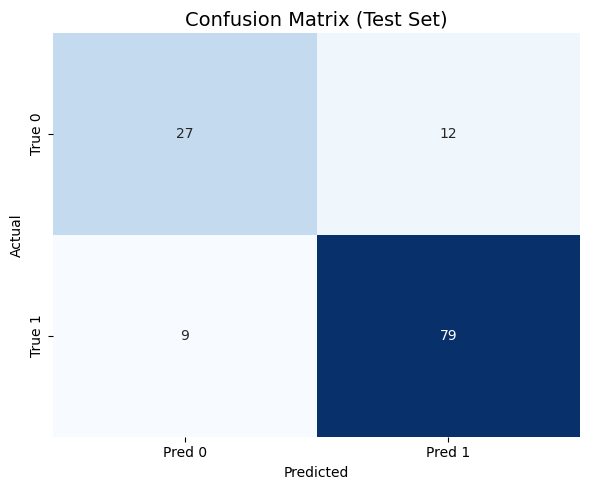

In [17]:
total_loss = 0
correct = 0
total = 0

all_preds = []
all_targets = []
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ------------------------------
# Run evaluation
# ------------------------------
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        out = model(X_batch)
        loss = criterion(out, y_batch)
        total_loss += loss.item()

        preds = (out >= 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

# ------------------------------
# Metrics
# ------------------------------
avg_loss = total_loss / len(test_loader)
accuracy = correct / total
cm = confusion_matrix(all_targets, all_preds)

print("\n===== TEST RESULTS =====")
print(f"Loss: {avg_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=['Class 0', 'Class 1']))

# ------------------------------
# Confusion matrix plot
# ------------------------------
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=['Pred 0', 'Pred 1'],
    yticklabels=['True 0', 'True 1']
)
plt.title("Confusion Matrix (Test Set)", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [9]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Load best model
# ------------------------------
model.load_state_dict(torch.load("binary_model.pth"))
model.eval()

total_val_loss = 0
correct_val = 0
total_val = 0

all_preds = []
all_targets = []

# ------------------------------
# Run evaluation
# ------------------------------
with torch.no_grad():
    for X_val_batch, y_val_batch in val_loader:
        val_out = model(X_val_batch)
        val_loss = criterion(val_out, y_val_batch)
        total_val_loss += val_loss.item()

        val_preds = (val_out >= 0.5).float()

        all_preds.extend(val_preds.cpu().numpy())
        all_targets.extend(y_val_batch.cpu().numpy())

        correct_val += (val_preds == y_val_batch).sum().item()
        total_val += y_val_batch.size(0)

# ------------------------------
# Metrics
# ------------------------------
avg_val_loss = total_val_loss / len(val_loader)
val_acc = correct_val / total_val
cm = confusion_matrix(all_targets, all_preds)

print("\n===== VALIDATION RESULTS =====")
print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=['Class 0', 'Class 1']))

# ------------------------------
# Nicely formatted confusion matrix plot
# ------------------------------
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=['Pred 0', 'Pred 1'],
    yticklabels=['True 0', 'True 1']
)
plt.title("Confusion Matrix (Validation Set)", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL sklearn.preprocessing._data.StandardScaler was not an allowed global by default. Please use `torch.serialization.add_safe_globals([sklearn.preprocessing._data.StandardScaler])` or the `torch.serialization.safe_globals([sklearn.preprocessing._data.StandardScaler])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.